# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 47kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

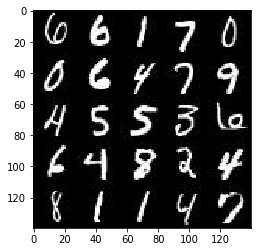

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

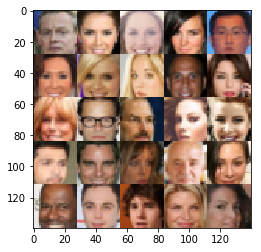

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    keep_prob=0.6
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02))
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.truncated_normal_initializer(0.0, 0.02))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        logits = tf.layers.dropout(logits, rate=keep_prob)
        out = tf.sigmoid(logits)

    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function 
    alpha = 0.18
    keep_prob=0.6
    with tf.variable_scope('generator', reuse=(not is_train)):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.nn.dropout(x2, keep_prob/4+3/4)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.nn.dropout(x3, (keep_prob+1)/2)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.nn.dropout(x4, keep_prob)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha*x4, x4)
        
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
        
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate_ref, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    
    _, image_width, image_height, image_channels = data_shape
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    
    input_real, input_z, learning_rate_p = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_p, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images = batch_images*2
                
                learning_rate = learning_rate_ref/5 + 8*learning_rate_ref/5/(1+np.exp(steps/500))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_p: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_p: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate_p: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Step {}...".format(steps),
                          "Learning rate {:.7f}...".format(learning_rate),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    last_show_step = steps
        
        if steps>last_show_step:
            show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Step 10... Learning rate 0.0009920... Discriminator Loss: 2.2775... Generator Loss: 0.7188
Epoch 1/2... Step 20... Learning rate 0.0009840... Discriminator Loss: 2.9252... Generator Loss: 0.1112
Epoch 1/2... Step 30... Learning rate 0.0009760... Discriminator Loss: 2.2719... Generator Loss: 0.4614
Epoch 1/2... Step 40... Learning rate 0.0009680... Discriminator Loss: 1.3937... Generator Loss: 0.6687
Epoch 1/2... Step 50... Learning rate 0.0009600... Discriminator Loss: 1.9173... Generator Loss: 0.5098
Epoch 1/2... Step 60... Learning rate 0.0009521... Discriminator Loss: 1.7320... Generator Loss: 0.3944
Epoch 1/2... Step 70... Learning rate 0.0009441... Discriminator Loss: 1.6214... Generator Loss: 0.9611
Epoch 1/2... Step 80... Learning rate 0.0009361... Discriminator Loss: 1.7000... Generator Loss: 0.6866
Epoch 1/2... Step 90... Learning rate 0.0009282... Discriminator Loss: 1.5797... Generator Loss: 0.9152
Epoch 1/2... Step 100... Learning rate 0.0009203... Discriminato

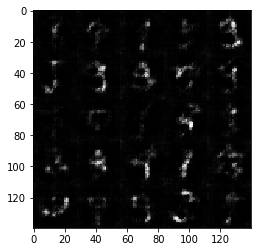

Epoch 1/2... Step 110... Learning rate 0.0009124... Discriminator Loss: 1.7533... Generator Loss: 0.4492
Epoch 1/2... Step 120... Learning rate 0.0009045... Discriminator Loss: 1.5358... Generator Loss: 0.5537
Epoch 1/2... Step 130... Learning rate 0.0008966... Discriminator Loss: 1.6012... Generator Loss: 0.7884
Epoch 1/2... Step 140... Learning rate 0.0008887... Discriminator Loss: 1.7767... Generator Loss: 0.3450
Epoch 1/2... Step 150... Learning rate 0.0008809... Discriminator Loss: 1.6327... Generator Loss: 0.6821
Epoch 1/2... Step 160... Learning rate 0.0008731... Discriminator Loss: 1.5040... Generator Loss: 0.6939
Epoch 1/2... Step 170... Learning rate 0.0008653... Discriminator Loss: 1.8165... Generator Loss: 0.3023
Epoch 1/2... Step 180... Learning rate 0.0008575... Discriminator Loss: 1.6804... Generator Loss: 0.7436
Epoch 1/2... Step 190... Learning rate 0.0008498... Discriminator Loss: 1.7889... Generator Loss: 0.3121
Epoch 1/2... Step 200... Learning rate 0.0008421... Dis

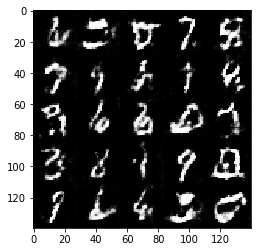

Epoch 1/2... Step 210... Learning rate 0.0008344... Discriminator Loss: 1.3910... Generator Loss: 0.5950
Epoch 1/2... Step 220... Learning rate 0.0008268... Discriminator Loss: 1.4622... Generator Loss: 0.8780
Epoch 1/2... Step 230... Learning rate 0.0008192... Discriminator Loss: 1.6693... Generator Loss: 0.3653
Epoch 1/2... Step 240... Learning rate 0.0008116... Discriminator Loss: 1.6396... Generator Loss: 0.9860
Epoch 1/2... Step 250... Learning rate 0.0008041... Discriminator Loss: 1.4953... Generator Loss: 0.5390
Epoch 1/2... Step 260... Learning rate 0.0007966... Discriminator Loss: 1.3827... Generator Loss: 0.5938
Epoch 1/2... Step 270... Learning rate 0.0007891... Discriminator Loss: 1.4392... Generator Loss: 0.5375
Epoch 1/2... Step 280... Learning rate 0.0007817... Discriminator Loss: 1.4834... Generator Loss: 0.5875
Epoch 1/2... Step 290... Learning rate 0.0007743... Discriminator Loss: 1.3906... Generator Loss: 0.8950
Epoch 1/2... Step 300... Learning rate 0.0007669... Dis

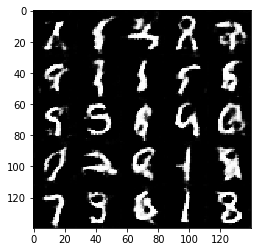

Epoch 1/2... Step 310... Learning rate 0.0007597... Discriminator Loss: 1.4342... Generator Loss: 0.4852
Epoch 1/2... Step 320... Learning rate 0.0007524... Discriminator Loss: 1.4622... Generator Loss: 1.0345
Epoch 1/2... Step 330... Learning rate 0.0007452... Discriminator Loss: 1.5135... Generator Loss: 0.5095
Epoch 1/2... Step 340... Learning rate 0.0007380... Discriminator Loss: 1.3381... Generator Loss: 0.6967
Epoch 1/2... Step 350... Learning rate 0.0007309... Discriminator Loss: 1.2852... Generator Loss: 1.2355
Epoch 1/2... Step 360... Learning rate 0.0007238... Discriminator Loss: 2.0101... Generator Loss: 1.9159
Epoch 1/2... Step 370... Learning rate 0.0007168... Discriminator Loss: 1.3644... Generator Loss: 0.6483
Epoch 1/2... Step 380... Learning rate 0.0007098... Discriminator Loss: 1.4989... Generator Loss: 0.5134
Epoch 1/2... Step 390... Learning rate 0.0007029... Discriminator Loss: 1.2842... Generator Loss: 0.8701
Epoch 1/2... Step 400... Learning rate 0.0006960... Dis

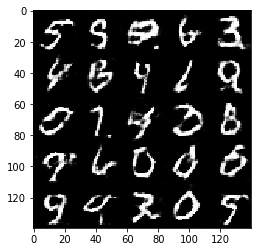

Epoch 1/2... Step 410... Learning rate 0.0006892... Discriminator Loss: 1.2965... Generator Loss: 0.6275
Epoch 1/2... Step 420... Learning rate 0.0006825... Discriminator Loss: 1.1155... Generator Loss: 1.2602
Epoch 1/2... Step 430... Learning rate 0.0006757... Discriminator Loss: 1.2974... Generator Loss: 0.6615
Epoch 1/2... Step 440... Learning rate 0.0006691... Discriminator Loss: 1.3341... Generator Loss: 1.1656
Epoch 1/2... Step 450... Learning rate 0.0006625... Discriminator Loss: 1.2020... Generator Loss: 0.8406
Epoch 1/2... Step 460... Learning rate 0.0006559... Discriminator Loss: 1.4946... Generator Loss: 0.4555
Epoch 1/2... Step 470... Learning rate 0.0006494... Discriminator Loss: 1.1483... Generator Loss: 0.8388
Epoch 1/2... Step 480... Learning rate 0.0006430... Discriminator Loss: 1.4300... Generator Loss: 0.5145
Epoch 1/2... Step 490... Learning rate 0.0006366... Discriminator Loss: 1.1040... Generator Loss: 0.9401
Epoch 1/2... Step 500... Learning rate 0.0006303... Dis

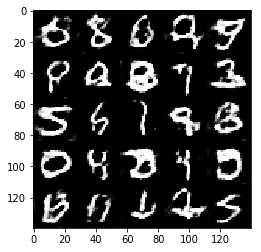

Epoch 1/2... Step 510... Learning rate 0.0006240... Discriminator Loss: 1.8061... Generator Loss: 0.2978
Epoch 1/2... Step 520... Learning rate 0.0006178... Discriminator Loss: 1.3496... Generator Loss: 0.8661
Epoch 1/2... Step 530... Learning rate 0.0006117... Discriminator Loss: 1.1618... Generator Loss: 0.7831
Epoch 1/2... Step 540... Learning rate 0.0006056... Discriminator Loss: 1.1929... Generator Loss: 0.8318
Epoch 1/2... Step 550... Learning rate 0.0005996... Discriminator Loss: 1.4581... Generator Loss: 0.5059
Epoch 1/2... Step 560... Learning rate 0.0005936... Discriminator Loss: 1.1557... Generator Loss: 1.0678
Epoch 1/2... Step 570... Learning rate 0.0005877... Discriminator Loss: 1.1817... Generator Loss: 0.9944
Epoch 1/2... Step 580... Learning rate 0.0005819... Discriminator Loss: 1.0893... Generator Loss: 0.9490
Epoch 1/2... Step 590... Learning rate 0.0005761... Discriminator Loss: 1.1533... Generator Loss: 1.0599
Epoch 1/2... Step 600... Learning rate 0.0005704... Dis

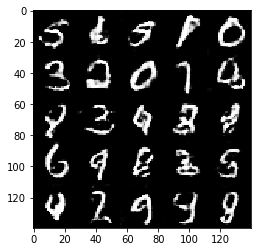

Epoch 1/2... Step 610... Learning rate 0.0005647... Discriminator Loss: 1.3651... Generator Loss: 0.5577
Epoch 1/2... Step 620... Learning rate 0.0005591... Discriminator Loss: 1.4383... Generator Loss: 0.5511
Epoch 1/2... Step 630... Learning rate 0.0005536... Discriminator Loss: 1.2375... Generator Loss: 1.5430
Epoch 1/2... Step 640... Learning rate 0.0005481... Discriminator Loss: 1.2918... Generator Loss: 0.6876
Epoch 1/2... Step 650... Learning rate 0.0005427... Discriminator Loss: 1.2733... Generator Loss: 0.6372
Epoch 1/2... Step 660... Learning rate 0.0005373... Discriminator Loss: 1.0873... Generator Loss: 0.9155
Epoch 1/2... Step 670... Learning rate 0.0005320... Discriminator Loss: 1.0743... Generator Loss: 0.9767
Epoch 1/2... Step 680... Learning rate 0.0005268... Discriminator Loss: 1.2229... Generator Loss: 1.6961
Epoch 1/2... Step 690... Learning rate 0.0005216... Discriminator Loss: 1.2747... Generator Loss: 0.5798
Epoch 1/2... Step 700... Learning rate 0.0005165... Dis

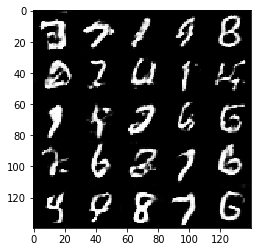

Epoch 1/2... Step 710... Learning rate 0.0005115... Discriminator Loss: 1.3212... Generator Loss: 0.6049
Epoch 1/2... Step 720... Learning rate 0.0005065... Discriminator Loss: 0.9496... Generator Loss: 0.9729
Epoch 1/2... Step 730... Learning rate 0.0005015... Discriminator Loss: 0.8524... Generator Loss: 1.6160
Epoch 1/2... Step 740... Learning rate 0.0004967... Discriminator Loss: 1.4888... Generator Loss: 0.4184
Epoch 1/2... Step 750... Learning rate 0.0004919... Discriminator Loss: 0.8279... Generator Loss: 1.2152
Epoch 1/2... Step 760... Learning rate 0.0004871... Discriminator Loss: 1.0702... Generator Loss: 0.8364
Epoch 1/2... Step 770... Learning rate 0.0004825... Discriminator Loss: 0.9580... Generator Loss: 1.2067
Epoch 1/2... Step 780... Learning rate 0.0004778... Discriminator Loss: 0.8205... Generator Loss: 1.2755
Epoch 1/2... Step 790... Learning rate 0.0004733... Discriminator Loss: 0.8670... Generator Loss: 2.2057
Epoch 1/2... Step 800... Learning rate 0.0004688... Dis

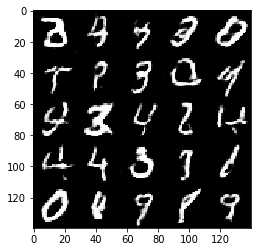

Epoch 1/2... Step 810... Learning rate 0.0004643... Discriminator Loss: 1.0842... Generator Loss: 0.8384
Epoch 1/2... Step 820... Learning rate 0.0004599... Discriminator Loss: 1.0575... Generator Loss: 0.8433
Epoch 1/2... Step 830... Learning rate 0.0004556... Discriminator Loss: 0.9447... Generator Loss: 1.1844
Epoch 1/2... Step 840... Learning rate 0.0004514... Discriminator Loss: 1.5678... Generator Loss: 0.4195
Epoch 1/2... Step 850... Learning rate 0.0004471... Discriminator Loss: 1.2672... Generator Loss: 0.7104
Epoch 1/2... Step 860... Learning rate 0.0004430... Discriminator Loss: 1.0196... Generator Loss: 0.8207
Epoch 1/2... Step 870... Learning rate 0.0004389... Discriminator Loss: 0.9874... Generator Loss: 0.7492
Epoch 1/2... Step 880... Learning rate 0.0004349... Discriminator Loss: 1.1964... Generator Loss: 0.6392
Epoch 1/2... Step 890... Learning rate 0.0004309... Discriminator Loss: 1.3219... Generator Loss: 0.5769
Epoch 1/2... Step 900... Learning rate 0.0004270... Dis

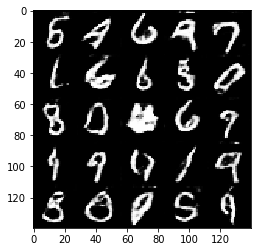

Epoch 1/2... Step 910... Learning rate 0.0004231... Discriminator Loss: 1.1096... Generator Loss: 0.7690
Epoch 1/2... Step 920... Learning rate 0.0004193... Discriminator Loss: 0.9478... Generator Loss: 1.4904
Epoch 1/2... Step 930... Learning rate 0.0004155... Discriminator Loss: 0.8641... Generator Loss: 1.5599
Epoch 1/2... Step 940... Learning rate 0.0004118... Discriminator Loss: 1.1272... Generator Loss: 0.7107
Epoch 1/2... Step 950... Learning rate 0.0004082... Discriminator Loss: 1.0430... Generator Loss: 1.9082
Epoch 1/2... Step 960... Learning rate 0.0004046... Discriminator Loss: 0.8364... Generator Loss: 1.3031
Epoch 1/2... Step 970... Learning rate 0.0004010... Discriminator Loss: 0.9053... Generator Loss: 1.1379
Epoch 1/2... Step 980... Learning rate 0.0003975... Discriminator Loss: 0.8376... Generator Loss: 1.5046
Epoch 1/2... Step 990... Learning rate 0.0003941... Discriminator Loss: 1.0101... Generator Loss: 0.7829
Epoch 1/2... Step 1000... Learning rate 0.0003907... Di

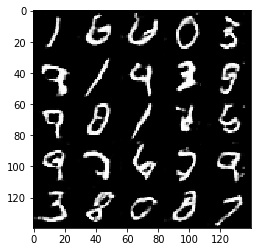

Epoch 1/2... Step 1010... Learning rate 0.0003874... Discriminator Loss: 1.0977... Generator Loss: 0.7704
Epoch 1/2... Step 1020... Learning rate 0.0003841... Discriminator Loss: 1.0244... Generator Loss: 0.9372
Epoch 1/2... Step 1030... Learning rate 0.0003809... Discriminator Loss: 1.0569... Generator Loss: 0.8437
Epoch 1/2... Step 1040... Learning rate 0.0003777... Discriminator Loss: 1.7947... Generator Loss: 0.4157
Epoch 1/2... Step 1050... Learning rate 0.0003746... Discriminator Loss: 1.1110... Generator Loss: 0.7947
Epoch 1/2... Step 1060... Learning rate 0.0003715... Discriminator Loss: 1.0854... Generator Loss: 1.0414
Epoch 1/2... Step 1070... Learning rate 0.0003684... Discriminator Loss: 0.7660... Generator Loss: 1.6970
Epoch 1/2... Step 1080... Learning rate 0.0003654... Discriminator Loss: 0.8591... Generator Loss: 1.0317
Epoch 1/2... Step 1090... Learning rate 0.0003625... Discriminator Loss: 1.0318... Generator Loss: 1.3562
Epoch 1/2... Step 1100... Learning rate 0.0003

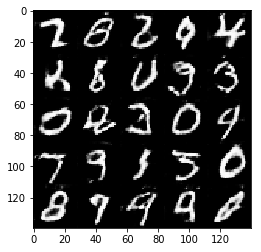

Epoch 1/2... Step 1110... Learning rate 0.0003568... Discriminator Loss: 1.0595... Generator Loss: 0.8849
Epoch 1/2... Step 1120... Learning rate 0.0003539... Discriminator Loss: 0.6326... Generator Loss: 1.6943
Epoch 1/2... Step 1130... Learning rate 0.0003512... Discriminator Loss: 0.7356... Generator Loss: 1.2732
Epoch 1/2... Step 1140... Learning rate 0.0003485... Discriminator Loss: 0.7759... Generator Loss: 1.3830
Epoch 1/2... Step 1150... Learning rate 0.0003458... Discriminator Loss: 0.8662... Generator Loss: 1.2111
Epoch 1/2... Step 1160... Learning rate 0.0003432... Discriminator Loss: 1.2335... Generator Loss: 1.6946
Epoch 1/2... Step 1170... Learning rate 0.0003406... Discriminator Loss: 0.8089... Generator Loss: 1.5307
Epoch 1/2... Step 1180... Learning rate 0.0003380... Discriminator Loss: 1.1672... Generator Loss: 2.8117
Epoch 1/2... Step 1190... Learning rate 0.0003355... Discriminator Loss: 0.5440... Generator Loss: 1.8696
Epoch 1/2... Step 1200... Learning rate 0.0003

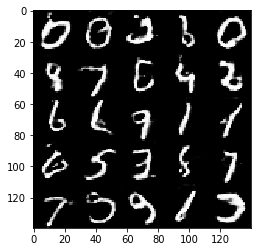

Epoch 1/2... Step 1210... Learning rate 0.0003307... Discriminator Loss: 1.0581... Generator Loss: 0.8540
Epoch 1/2... Step 1220... Learning rate 0.0003283... Discriminator Loss: 1.2337... Generator Loss: 0.7129
Epoch 1/2... Step 1230... Learning rate 0.0003259... Discriminator Loss: 0.9408... Generator Loss: 0.8954
Epoch 1/2... Step 1240... Learning rate 0.0003236... Discriminator Loss: 0.6458... Generator Loss: 1.7081
Epoch 1/2... Step 1250... Learning rate 0.0003214... Discriminator Loss: 0.6537... Generator Loss: 1.9235
Epoch 1/2... Step 1260... Learning rate 0.0003191... Discriminator Loss: 0.8624... Generator Loss: 1.1001
Epoch 1/2... Step 1270... Learning rate 0.0003170... Discriminator Loss: 0.7245... Generator Loss: 1.7149
Epoch 1/2... Step 1280... Learning rate 0.0003148... Discriminator Loss: 0.7198... Generator Loss: 1.6412
Epoch 1/2... Step 1290... Learning rate 0.0003127... Discriminator Loss: 0.6644... Generator Loss: 1.4528
Epoch 1/2... Step 1300... Learning rate 0.0003

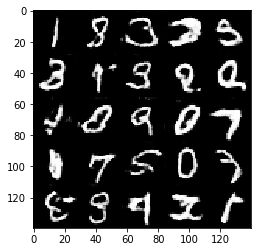

Epoch 1/2... Step 1310... Learning rate 0.0003086... Discriminator Loss: 0.7276... Generator Loss: 2.3028
Epoch 1/2... Step 1320... Learning rate 0.0003066... Discriminator Loss: 0.5829... Generator Loss: 2.0904
Epoch 1/2... Step 1330... Learning rate 0.0003046... Discriminator Loss: 0.5507... Generator Loss: 1.6995
Epoch 1/2... Step 1340... Learning rate 0.0003027... Discriminator Loss: 1.1740... Generator Loss: 0.6875
Epoch 1/2... Step 1350... Learning rate 0.0003008... Discriminator Loss: 0.7611... Generator Loss: 1.1828
Epoch 1/2... Step 1360... Learning rate 0.0002989... Discriminator Loss: 0.7964... Generator Loss: 1.0617
Epoch 1/2... Step 1370... Learning rate 0.0002970... Discriminator Loss: 0.5626... Generator Loss: 2.0345
Epoch 1/2... Step 1380... Learning rate 0.0002952... Discriminator Loss: 1.0657... Generator Loss: 1.2806
Epoch 1/2... Step 1390... Learning rate 0.0002935... Discriminator Loss: 0.5552... Generator Loss: 2.0653
Epoch 1/2... Step 1400... Learning rate 0.0002

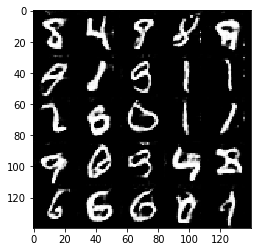

Epoch 1/2... Step 1410... Learning rate 0.0002900... Discriminator Loss: 0.8346... Generator Loss: 1.1844
Epoch 1/2... Step 1420... Learning rate 0.0002883... Discriminator Loss: 0.6750... Generator Loss: 1.9641
Epoch 1/2... Step 1430... Learning rate 0.0002867... Discriminator Loss: 0.6253... Generator Loss: 1.7891
Epoch 1/2... Step 1440... Learning rate 0.0002850... Discriminator Loss: 0.6828... Generator Loss: 1.7676
Epoch 1/2... Step 1450... Learning rate 0.0002834... Discriminator Loss: 0.7957... Generator Loss: 2.6642
Epoch 1/2... Step 1460... Learning rate 0.0002819... Discriminator Loss: 0.5766... Generator Loss: 1.5214
Epoch 1/2... Step 1470... Learning rate 0.0002803... Discriminator Loss: 0.6395... Generator Loss: 1.8529
Epoch 1/2... Step 1480... Learning rate 0.0002788... Discriminator Loss: 0.5612... Generator Loss: 1.8776
Epoch 1/2... Step 1490... Learning rate 0.0002773... Discriminator Loss: 0.6385... Generator Loss: 1.7686
Epoch 1/2... Step 1500... Learning rate 0.0002

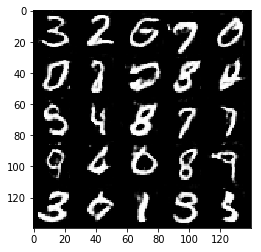

Epoch 1/2... Step 1510... Learning rate 0.0002744... Discriminator Loss: 0.7899... Generator Loss: 1.3020
Epoch 1/2... Step 1520... Learning rate 0.0002730... Discriminator Loss: 0.8280... Generator Loss: 1.4111
Epoch 1/2... Step 1530... Learning rate 0.0002717... Discriminator Loss: 0.6665... Generator Loss: 1.5799
Epoch 1/2... Step 1540... Learning rate 0.0002703... Discriminator Loss: 0.6897... Generator Loss: 1.1572
Epoch 1/2... Step 1550... Learning rate 0.0002690... Discriminator Loss: 0.7059... Generator Loss: 1.5202
Epoch 1/2... Step 1560... Learning rate 0.0002677... Discriminator Loss: 0.7371... Generator Loss: 1.3313
Epoch 1/2... Step 1570... Learning rate 0.0002664... Discriminator Loss: 0.7000... Generator Loss: 2.2084
Epoch 1/2... Step 1580... Learning rate 0.0002651... Discriminator Loss: 0.6646... Generator Loss: 1.4924
Epoch 1/2... Step 1590... Learning rate 0.0002639... Discriminator Loss: 0.7821... Generator Loss: 1.4952
Epoch 1/2... Step 1600... Learning rate 0.0002

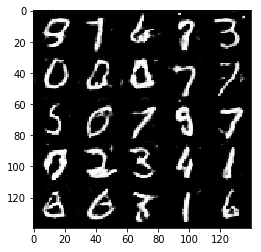

Epoch 1/2... Step 1610... Learning rate 0.0002615... Discriminator Loss: 0.8451... Generator Loss: 1.1512
Epoch 1/2... Step 1620... Learning rate 0.0002603... Discriminator Loss: 0.8675... Generator Loss: 1.4837
Epoch 1/2... Step 1630... Learning rate 0.0002592... Discriminator Loss: 0.7359... Generator Loss: 1.2309
Epoch 1/2... Step 1640... Learning rate 0.0002580... Discriminator Loss: 0.5569... Generator Loss: 2.4547
Epoch 1/2... Step 1650... Learning rate 0.0002569... Discriminator Loss: 0.4671... Generator Loss: 2.3589
Epoch 1/2... Step 1660... Learning rate 0.0002558... Discriminator Loss: 0.4975... Generator Loss: 2.2264
Epoch 1/2... Step 1670... Learning rate 0.0002548... Discriminator Loss: 0.7807... Generator Loss: 1.3504
Epoch 1/2... Step 1680... Learning rate 0.0002537... Discriminator Loss: 0.6999... Generator Loss: 2.4035
Epoch 1/2... Step 1690... Learning rate 0.0002527... Discriminator Loss: 0.6044... Generator Loss: 2.0778
Epoch 1/2... Step 1700... Learning rate 0.0002

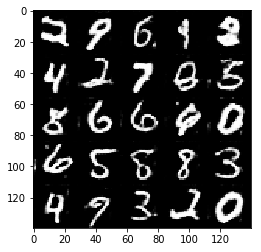

Epoch 1/2... Step 1710... Learning rate 0.0002507... Discriminator Loss: 0.7182... Generator Loss: 1.5146
Epoch 1/2... Step 1720... Learning rate 0.0002497... Discriminator Loss: 0.5255... Generator Loss: 2.4551
Epoch 1/2... Step 1730... Learning rate 0.0002488... Discriminator Loss: 0.4870... Generator Loss: 2.3825
Epoch 1/2... Step 1740... Learning rate 0.0002478... Discriminator Loss: 0.4344... Generator Loss: 3.0653
Epoch 1/2... Step 1750... Learning rate 0.0002469... Discriminator Loss: 0.4957... Generator Loss: 1.7074
Epoch 1/2... Step 1760... Learning rate 0.0002460... Discriminator Loss: 0.4688... Generator Loss: 2.5697
Epoch 1/2... Step 1770... Learning rate 0.0002451... Discriminator Loss: 0.7078... Generator Loss: 1.5785
Epoch 1/2... Step 1780... Learning rate 0.0002442... Discriminator Loss: 0.6404... Generator Loss: 1.9567
Epoch 1/2... Step 1790... Learning rate 0.0002434... Discriminator Loss: 0.6814... Generator Loss: 1.8428
Epoch 1/2... Step 1800... Learning rate 0.0002

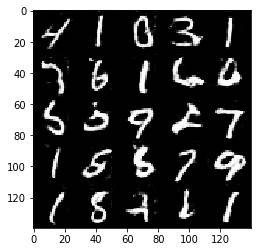

Epoch 1/2... Step 1810... Learning rate 0.0002417... Discriminator Loss: 0.7248... Generator Loss: 1.6335
Epoch 1/2... Step 1820... Learning rate 0.0002409... Discriminator Loss: 0.5548... Generator Loss: 2.3637
Epoch 1/2... Step 1830... Learning rate 0.0002401... Discriminator Loss: 0.4808... Generator Loss: 1.9968
Epoch 1/2... Step 1840... Learning rate 0.0002394... Discriminator Loss: 0.5712... Generator Loss: 2.2116
Epoch 1/2... Step 1850... Learning rate 0.0002386... Discriminator Loss: 0.4027... Generator Loss: 2.5912
Epoch 1/2... Step 1860... Learning rate 0.0002379... Discriminator Loss: 0.7253... Generator Loss: 1.5722
Epoch 1/2... Step 1870... Learning rate 0.0002371... Discriminator Loss: 0.6042... Generator Loss: 1.8596
Epoch 2/2... Step 1880... Learning rate 0.0002364... Discriminator Loss: 0.6215... Generator Loss: 1.6889
Epoch 2/2... Step 1890... Learning rate 0.0002357... Discriminator Loss: 0.7003... Generator Loss: 1.2865
Epoch 2/2... Step 1900... Learning rate 0.0002

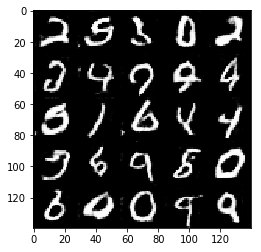

Epoch 2/2... Step 1910... Learning rate 0.0002343... Discriminator Loss: 0.5545... Generator Loss: 1.8063
Epoch 2/2... Step 1920... Learning rate 0.0002337... Discriminator Loss: 0.7641... Generator Loss: 1.3742
Epoch 2/2... Step 1930... Learning rate 0.0002330... Discriminator Loss: 0.9731... Generator Loss: 1.1899
Epoch 2/2... Step 1940... Learning rate 0.0002324... Discriminator Loss: 0.7918... Generator Loss: 1.0223
Epoch 2/2... Step 1950... Learning rate 0.0002317... Discriminator Loss: 0.4291... Generator Loss: 2.4377
Epoch 2/2... Step 1960... Learning rate 0.0002311... Discriminator Loss: 0.4970... Generator Loss: 2.2318
Epoch 2/2... Step 1970... Learning rate 0.0002305... Discriminator Loss: 0.4539... Generator Loss: 3.3344
Epoch 2/2... Step 1980... Learning rate 0.0002299... Discriminator Loss: 0.6633... Generator Loss: 1.3451
Epoch 2/2... Step 1990... Learning rate 0.0002293... Discriminator Loss: 0.7170... Generator Loss: 1.5673
Epoch 2/2... Step 2000... Learning rate 0.0002

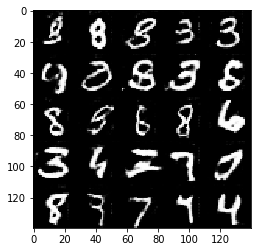

Epoch 2/2... Step 2010... Learning rate 0.0002282... Discriminator Loss: 0.6549... Generator Loss: 1.5711
Epoch 2/2... Step 2020... Learning rate 0.0002277... Discriminator Loss: 0.6884... Generator Loss: 1.7700
Epoch 2/2... Step 2030... Learning rate 0.0002271... Discriminator Loss: 0.5390... Generator Loss: 1.5352
Epoch 2/2... Step 2040... Learning rate 0.0002266... Discriminator Loss: 0.4642... Generator Loss: 2.4821
Epoch 2/2... Step 2050... Learning rate 0.0002261... Discriminator Loss: 0.9810... Generator Loss: 1.1837
Epoch 2/2... Step 2060... Learning rate 0.0002256... Discriminator Loss: 0.6434... Generator Loss: 1.9212
Epoch 2/2... Step 2070... Learning rate 0.0002251... Discriminator Loss: 0.5573... Generator Loss: 2.0602
Epoch 2/2... Step 2080... Learning rate 0.0002246... Discriminator Loss: 0.5175... Generator Loss: 2.4802
Epoch 2/2... Step 2090... Learning rate 0.0002241... Discriminator Loss: 0.5964... Generator Loss: 2.2866
Epoch 2/2... Step 2100... Learning rate 0.0002

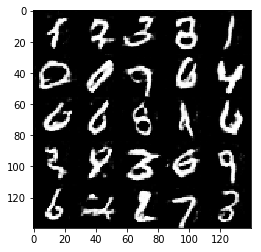

Epoch 2/2... Step 2110... Learning rate 0.0002232... Discriminator Loss: 0.8337... Generator Loss: 3.3492
Epoch 2/2... Step 2120... Learning rate 0.0002227... Discriminator Loss: 0.4850... Generator Loss: 2.5861
Epoch 2/2... Step 2130... Learning rate 0.0002223... Discriminator Loss: 0.9126... Generator Loss: 0.9177
Epoch 2/2... Step 2140... Learning rate 0.0002218... Discriminator Loss: 0.6638... Generator Loss: 1.8233
Epoch 2/2... Step 2150... Learning rate 0.0002214... Discriminator Loss: 0.4290... Generator Loss: 3.6434
Epoch 2/2... Step 2160... Learning rate 0.0002210... Discriminator Loss: 0.4812... Generator Loss: 2.6530
Epoch 2/2... Step 2170... Learning rate 0.0002206... Discriminator Loss: 0.5658... Generator Loss: 1.5815
Epoch 2/2... Step 2180... Learning rate 0.0002202... Discriminator Loss: 0.5877... Generator Loss: 2.3314
Epoch 2/2... Step 2190... Learning rate 0.0002198... Discriminator Loss: 0.4648... Generator Loss: 2.2287
Epoch 2/2... Step 2200... Learning rate 0.0002

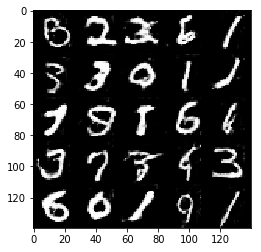

Epoch 2/2... Step 2210... Learning rate 0.0002190... Discriminator Loss: 0.4681... Generator Loss: 2.6041
Epoch 2/2... Step 2220... Learning rate 0.0002187... Discriminator Loss: 0.5223... Generator Loss: 2.4818
Epoch 2/2... Step 2230... Learning rate 0.0002183... Discriminator Loss: 0.5268... Generator Loss: 2.5154
Epoch 2/2... Step 2240... Learning rate 0.0002179... Discriminator Loss: 0.5570... Generator Loss: 1.5873
Epoch 2/2... Step 2250... Learning rate 0.0002176... Discriminator Loss: 0.5091... Generator Loss: 2.2205
Epoch 2/2... Step 2260... Learning rate 0.0002172... Discriminator Loss: 0.4558... Generator Loss: 2.7180
Epoch 2/2... Step 2270... Learning rate 0.0002169... Discriminator Loss: 0.4811... Generator Loss: 3.3146
Epoch 2/2... Step 2280... Learning rate 0.0002166... Discriminator Loss: 0.8199... Generator Loss: 1.3634
Epoch 2/2... Step 2290... Learning rate 0.0002162... Discriminator Loss: 0.5765... Generator Loss: 2.0730
Epoch 2/2... Step 2300... Learning rate 0.0002

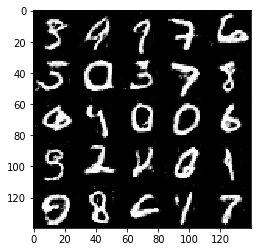

Epoch 2/2... Step 2310... Learning rate 0.0002156... Discriminator Loss: 0.4984... Generator Loss: 1.8849
Epoch 2/2... Step 2320... Learning rate 0.0002153... Discriminator Loss: 0.8265... Generator Loss: 1.1251
Epoch 2/2... Step 2330... Learning rate 0.0002150... Discriminator Loss: 0.4971... Generator Loss: 2.9444
Epoch 2/2... Step 2340... Learning rate 0.0002147... Discriminator Loss: 0.5723... Generator Loss: 2.7930
Epoch 2/2... Step 2350... Learning rate 0.0002144... Discriminator Loss: 0.4531... Generator Loss: 2.2449
Epoch 2/2... Step 2360... Learning rate 0.0002141... Discriminator Loss: 0.4999... Generator Loss: 2.9357
Epoch 2/2... Step 2370... Learning rate 0.0002139... Discriminator Loss: 0.4411... Generator Loss: 3.0440
Epoch 2/2... Step 2380... Learning rate 0.0002136... Discriminator Loss: 0.6069... Generator Loss: 2.2436
Epoch 2/2... Step 2390... Learning rate 0.0002133... Discriminator Loss: 0.4528... Generator Loss: 2.4815
Epoch 2/2... Step 2400... Learning rate 0.0002

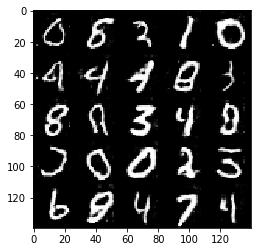

Epoch 2/2... Step 2410... Learning rate 0.0002128... Discriminator Loss: 0.8006... Generator Loss: 1.4114
Epoch 2/2... Step 2420... Learning rate 0.0002126... Discriminator Loss: 0.4588... Generator Loss: 2.6977
Epoch 2/2... Step 2430... Learning rate 0.0002123... Discriminator Loss: 0.4384... Generator Loss: 3.5928
Epoch 2/2... Step 2440... Learning rate 0.0002121... Discriminator Loss: 0.5330... Generator Loss: 2.2557
Epoch 2/2... Step 2450... Learning rate 0.0002118... Discriminator Loss: 0.5869... Generator Loss: 2.0192
Epoch 2/2... Step 2460... Learning rate 0.0002116... Discriminator Loss: 0.4300... Generator Loss: 3.2430
Epoch 2/2... Step 2470... Learning rate 0.0002114... Discriminator Loss: 0.6045... Generator Loss: 1.8437
Epoch 2/2... Step 2480... Learning rate 0.0002111... Discriminator Loss: 0.4210... Generator Loss: 2.9991
Epoch 2/2... Step 2490... Learning rate 0.0002109... Discriminator Loss: 0.6484... Generator Loss: 2.2532
Epoch 2/2... Step 2500... Learning rate 0.0002

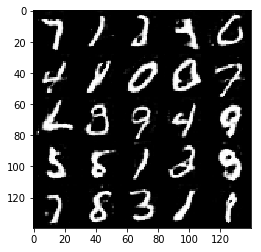

Epoch 2/2... Step 2510... Learning rate 0.0002105... Discriminator Loss: 0.4561... Generator Loss: 2.2943
Epoch 2/2... Step 2520... Learning rate 0.0002103... Discriminator Loss: 2.0342... Generator Loss: 0.4562
Epoch 2/2... Step 2530... Learning rate 0.0002101... Discriminator Loss: 0.5532... Generator Loss: 2.0082
Epoch 2/2... Step 2540... Learning rate 0.0002099... Discriminator Loss: 0.6253... Generator Loss: 1.8905
Epoch 2/2... Step 2550... Learning rate 0.0002097... Discriminator Loss: 0.6450... Generator Loss: 1.8730
Epoch 2/2... Step 2560... Learning rate 0.0002095... Discriminator Loss: 0.5771... Generator Loss: 1.5807
Epoch 2/2... Step 2570... Learning rate 0.0002093... Discriminator Loss: 0.5866... Generator Loss: 1.9191
Epoch 2/2... Step 2580... Learning rate 0.0002091... Discriminator Loss: 0.7920... Generator Loss: 1.4753
Epoch 2/2... Step 2590... Learning rate 0.0002090... Discriminator Loss: 0.5764... Generator Loss: 2.4103
Epoch 2/2... Step 2600... Learning rate 0.0002

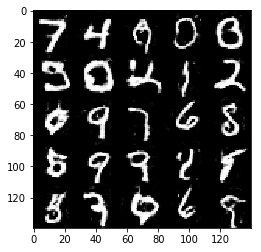

Epoch 2/2... Step 2610... Learning rate 0.0002086... Discriminator Loss: 0.5649... Generator Loss: 2.2356
Epoch 2/2... Step 2620... Learning rate 0.0002084... Discriminator Loss: 1.0050... Generator Loss: 0.9114
Epoch 2/2... Step 2630... Learning rate 0.0002083... Discriminator Loss: 0.5437... Generator Loss: 2.1034
Epoch 2/2... Step 2640... Learning rate 0.0002081... Discriminator Loss: 0.4571... Generator Loss: 2.2371
Epoch 2/2... Step 2650... Learning rate 0.0002079... Discriminator Loss: 0.5910... Generator Loss: 2.2436
Epoch 2/2... Step 2660... Learning rate 0.0002078... Discriminator Loss: 0.4287... Generator Loss: 2.8170
Epoch 2/2... Step 2670... Learning rate 0.0002076... Discriminator Loss: 0.5510... Generator Loss: 2.2088
Epoch 2/2... Step 2680... Learning rate 0.0002075... Discriminator Loss: 0.5992... Generator Loss: 1.7966
Epoch 2/2... Step 2690... Learning rate 0.0002073... Discriminator Loss: 0.4045... Generator Loss: 3.1646
Epoch 2/2... Step 2700... Learning rate 0.0002

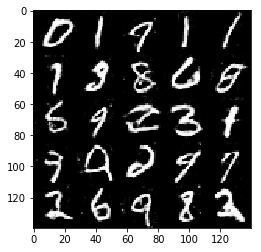

Epoch 2/2... Step 2710... Learning rate 0.0002071... Discriminator Loss: 0.4590... Generator Loss: 2.2113
Epoch 2/2... Step 2720... Learning rate 0.0002069... Discriminator Loss: 0.4988... Generator Loss: 2.3611
Epoch 2/2... Step 2730... Learning rate 0.0002068... Discriminator Loss: 0.4017... Generator Loss: 2.8663
Epoch 2/2... Step 2740... Learning rate 0.0002066... Discriminator Loss: 0.9335... Generator Loss: 1.4282
Epoch 2/2... Step 2750... Learning rate 0.0002065... Discriminator Loss: 0.4357... Generator Loss: 2.9638
Epoch 2/2... Step 2760... Learning rate 0.0002064... Discriminator Loss: 0.4866... Generator Loss: 2.1191
Epoch 2/2... Step 2770... Learning rate 0.0002063... Discriminator Loss: 0.5544... Generator Loss: 2.3836
Epoch 2/2... Step 2780... Learning rate 0.0002061... Discriminator Loss: 0.4674... Generator Loss: 3.0633
Epoch 2/2... Step 2790... Learning rate 0.0002060... Discriminator Loss: 0.4999... Generator Loss: 2.1603
Epoch 2/2... Step 2800... Learning rate 0.0002

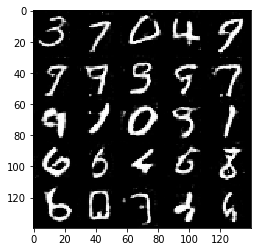

Epoch 2/2... Step 2810... Learning rate 0.0002058... Discriminator Loss: 0.4739... Generator Loss: 2.4885
Epoch 2/2... Step 2820... Learning rate 0.0002057... Discriminator Loss: 0.4637... Generator Loss: 2.3007
Epoch 2/2... Step 2830... Learning rate 0.0002056... Discriminator Loss: 0.5147... Generator Loss: 2.1034
Epoch 2/2... Step 2840... Learning rate 0.0002054... Discriminator Loss: 0.3911... Generator Loss: 4.1312
Epoch 2/2... Step 2850... Learning rate 0.0002053... Discriminator Loss: 0.5700... Generator Loss: 1.9902
Epoch 2/2... Step 2860... Learning rate 0.0002052... Discriminator Loss: 0.4064... Generator Loss: 2.9010
Epoch 2/2... Step 2870... Learning rate 0.0002051... Discriminator Loss: 0.4601... Generator Loss: 2.7742
Epoch 2/2... Step 2880... Learning rate 0.0002050... Discriminator Loss: 0.3920... Generator Loss: 3.2273
Epoch 2/2... Step 2890... Learning rate 0.0002049... Discriminator Loss: 0.5079... Generator Loss: 2.1156
Epoch 2/2... Step 2900... Learning rate 0.0002

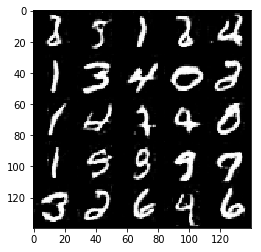

Epoch 2/2... Step 2910... Learning rate 0.0002047... Discriminator Loss: 0.4900... Generator Loss: 2.5955
Epoch 2/2... Step 2920... Learning rate 0.0002046... Discriminator Loss: 0.5562... Generator Loss: 2.3001
Epoch 2/2... Step 2930... Learning rate 0.0002045... Discriminator Loss: 0.6744... Generator Loss: 1.7960
Epoch 2/2... Step 2940... Learning rate 0.0002045... Discriminator Loss: 0.5782... Generator Loss: 3.3718
Epoch 2/2... Step 2950... Learning rate 0.0002044... Discriminator Loss: 0.6600... Generator Loss: 2.6154
Epoch 2/2... Step 2960... Learning rate 0.0002043... Discriminator Loss: 0.8754... Generator Loss: 1.0017
Epoch 2/2... Step 2970... Learning rate 0.0002042... Discriminator Loss: 0.5546... Generator Loss: 3.4475
Epoch 2/2... Step 2980... Learning rate 0.0002041... Discriminator Loss: 0.4102... Generator Loss: 3.0735
Epoch 2/2... Step 2990... Learning rate 0.0002040... Discriminator Loss: 0.4321... Generator Loss: 2.5930
Epoch 2/2... Step 3000... Learning rate 0.0002

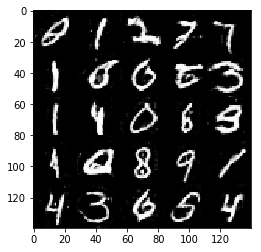

Epoch 2/2... Step 3010... Learning rate 0.0002039... Discriminator Loss: 0.5931... Generator Loss: 1.3502
Epoch 2/2... Step 3020... Learning rate 0.0002038... Discriminator Loss: 0.4748... Generator Loss: 2.2515
Epoch 2/2... Step 3030... Learning rate 0.0002037... Discriminator Loss: 0.4806... Generator Loss: 2.0464
Epoch 2/2... Step 3040... Learning rate 0.0002037... Discriminator Loss: 0.7404... Generator Loss: 2.5730
Epoch 2/2... Step 3050... Learning rate 0.0002036... Discriminator Loss: 0.4912... Generator Loss: 2.4001
Epoch 2/2... Step 3060... Learning rate 0.0002035... Discriminator Loss: 0.6264... Generator Loss: 1.2875
Epoch 2/2... Step 3070... Learning rate 0.0002034... Discriminator Loss: 0.7648... Generator Loss: 1.6590
Epoch 2/2... Step 3080... Learning rate 0.0002034... Discriminator Loss: 1.2088... Generator Loss: 0.8138
Epoch 2/2... Step 3090... Learning rate 0.0002033... Discriminator Loss: 0.8230... Generator Loss: 1.0425
Epoch 2/2... Step 3100... Learning rate 0.0002

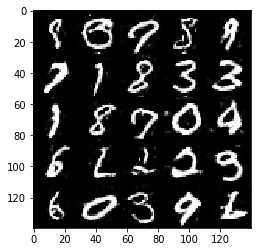

Epoch 2/2... Step 3110... Learning rate 0.0002032... Discriminator Loss: 0.4314... Generator Loss: 2.8433
Epoch 2/2... Step 3120... Learning rate 0.0002031... Discriminator Loss: 0.4693... Generator Loss: 2.4319
Epoch 2/2... Step 3130... Learning rate 0.0002031... Discriminator Loss: 0.4363... Generator Loss: 2.7593
Epoch 2/2... Step 3140... Learning rate 0.0002030... Discriminator Loss: 0.6278... Generator Loss: 1.7931
Epoch 2/2... Step 3150... Learning rate 0.0002029... Discriminator Loss: 0.4472... Generator Loss: 2.6111
Epoch 2/2... Step 3160... Learning rate 0.0002029... Discriminator Loss: 0.6158... Generator Loss: 1.4521
Epoch 2/2... Step 3170... Learning rate 0.0002028... Discriminator Loss: 0.4051... Generator Loss: 3.0543
Epoch 2/2... Step 3180... Learning rate 0.0002028... Discriminator Loss: 0.4777... Generator Loss: 3.0048
Epoch 2/2... Step 3190... Learning rate 0.0002027... Discriminator Loss: 0.5081... Generator Loss: 2.4629
Epoch 2/2... Step 3200... Learning rate 0.0002

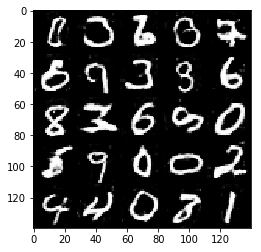

Epoch 2/2... Step 3210... Learning rate 0.0002026... Discriminator Loss: 0.8170... Generator Loss: 1.5276
Epoch 2/2... Step 3220... Learning rate 0.0002026... Discriminator Loss: 0.4979... Generator Loss: 2.3138
Epoch 2/2... Step 3230... Learning rate 0.0002025... Discriminator Loss: 0.5390... Generator Loss: 3.3034
Epoch 2/2... Step 3240... Learning rate 0.0002025... Discriminator Loss: 0.9505... Generator Loss: 1.0664
Epoch 2/2... Step 3250... Learning rate 0.0002024... Discriminator Loss: 0.4548... Generator Loss: 2.4955
Epoch 2/2... Step 3260... Learning rate 0.0002024... Discriminator Loss: 0.4891... Generator Loss: 2.7126
Epoch 2/2... Step 3270... Learning rate 0.0002023... Discriminator Loss: 0.8807... Generator Loss: 1.7246
Epoch 2/2... Step 3280... Learning rate 0.0002023... Discriminator Loss: 0.3970... Generator Loss: 3.4308
Epoch 2/2... Step 3290... Learning rate 0.0002022... Discriminator Loss: 0.5780... Generator Loss: 2.3236
Epoch 2/2... Step 3300... Learning rate 0.0002

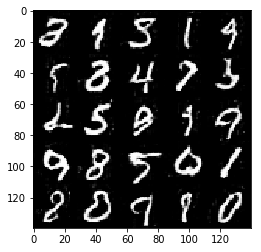

Epoch 2/2... Step 3310... Learning rate 0.0002021... Discriminator Loss: 0.4895... Generator Loss: 2.8301
Epoch 2/2... Step 3320... Learning rate 0.0002021... Discriminator Loss: 0.4237... Generator Loss: 2.9280
Epoch 2/2... Step 3330... Learning rate 0.0002020... Discriminator Loss: 0.4306... Generator Loss: 3.3449
Epoch 2/2... Step 3340... Learning rate 0.0002020... Discriminator Loss: 0.4591... Generator Loss: 2.7230
Epoch 2/2... Step 3350... Learning rate 0.0002020... Discriminator Loss: 0.4461... Generator Loss: 2.5011
Epoch 2/2... Step 3360... Learning rate 0.0002019... Discriminator Loss: 0.4808... Generator Loss: 3.3326
Epoch 2/2... Step 3370... Learning rate 0.0002019... Discriminator Loss: 0.4553... Generator Loss: 2.7085
Epoch 2/2... Step 3380... Learning rate 0.0002019... Discriminator Loss: 0.3867... Generator Loss: 2.9886
Epoch 2/2... Step 3390... Learning rate 0.0002018... Discriminator Loss: 0.3886... Generator Loss: 3.1199
Epoch 2/2... Step 3400... Learning rate 0.0002

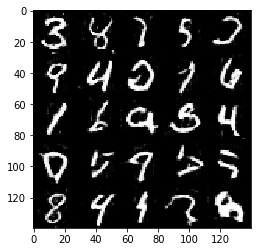

Epoch 2/2... Step 3410... Learning rate 0.0002017... Discriminator Loss: 0.5323... Generator Loss: 2.7190
Epoch 2/2... Step 3420... Learning rate 0.0002017... Discriminator Loss: 0.4323... Generator Loss: 4.2693
Epoch 2/2... Step 3430... Learning rate 0.0002017... Discriminator Loss: 0.4002... Generator Loss: 3.2933
Epoch 2/2... Step 3440... Learning rate 0.0002016... Discriminator Loss: 0.6137... Generator Loss: 1.6301
Epoch 2/2... Step 3450... Learning rate 0.0002016... Discriminator Loss: 0.7376... Generator Loss: 1.1325
Epoch 2/2... Step 3460... Learning rate 0.0002016... Discriminator Loss: 0.4912... Generator Loss: 2.1520
Epoch 2/2... Step 3470... Learning rate 0.0002015... Discriminator Loss: 0.3799... Generator Loss: 4.1168
Epoch 2/2... Step 3480... Learning rate 0.0002015... Discriminator Loss: 0.5104... Generator Loss: 2.6074
Epoch 2/2... Step 3490... Learning rate 0.0002015... Discriminator Loss: 0.6717... Generator Loss: 1.5329
Epoch 2/2... Step 3500... Learning rate 0.0002

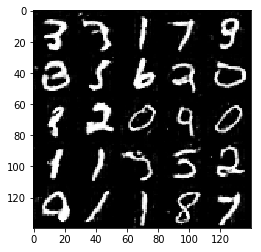

Epoch 2/2... Step 3510... Learning rate 0.0002014... Discriminator Loss: 0.4617... Generator Loss: 2.5596
Epoch 2/2... Step 3520... Learning rate 0.0002014... Discriminator Loss: 0.4933... Generator Loss: 2.5258
Epoch 2/2... Step 3530... Learning rate 0.0002014... Discriminator Loss: 0.4988... Generator Loss: 3.3291
Epoch 2/2... Step 3540... Learning rate 0.0002013... Discriminator Loss: 0.4456... Generator Loss: 2.0728
Epoch 2/2... Step 3550... Learning rate 0.0002013... Discriminator Loss: 0.4215... Generator Loss: 3.2556
Epoch 2/2... Step 3560... Learning rate 0.0002013... Discriminator Loss: 0.4447... Generator Loss: 2.5825
Epoch 2/2... Step 3570... Learning rate 0.0002013... Discriminator Loss: 0.3906... Generator Loss: 4.1924
Epoch 2/2... Step 3580... Learning rate 0.0002012... Discriminator Loss: 0.7796... Generator Loss: 4.6257
Epoch 2/2... Step 3590... Learning rate 0.0002012... Discriminator Loss: 0.6603... Generator Loss: 2.0202
Epoch 2/2... Step 3600... Learning rate 0.0002

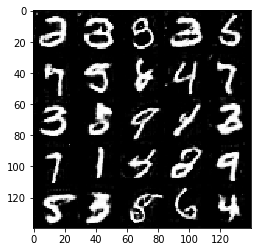

Epoch 2/2... Step 3610... Learning rate 0.0002012... Discriminator Loss: 0.5174... Generator Loss: 3.0267
Epoch 2/2... Step 3620... Learning rate 0.0002011... Discriminator Loss: 0.4211... Generator Loss: 3.1594
Epoch 2/2... Step 3630... Learning rate 0.0002011... Discriminator Loss: 0.3628... Generator Loss: 5.2336
Epoch 2/2... Step 3640... Learning rate 0.0002011... Discriminator Loss: 0.3865... Generator Loss: 2.8698
Epoch 2/2... Step 3650... Learning rate 0.0002011... Discriminator Loss: 0.4494... Generator Loss: 2.4562
Epoch 2/2... Step 3660... Learning rate 0.0002011... Discriminator Loss: 0.5186... Generator Loss: 2.4148
Epoch 2/2... Step 3670... Learning rate 0.0002010... Discriminator Loss: 0.4397... Generator Loss: 2.4537
Epoch 2/2... Step 3680... Learning rate 0.0002010... Discriminator Loss: 0.4885... Generator Loss: 2.4368
Epoch 2/2... Step 3690... Learning rate 0.0002010... Discriminator Loss: 0.4558... Generator Loss: 2.5945
Epoch 2/2... Step 3700... Learning rate 0.0002

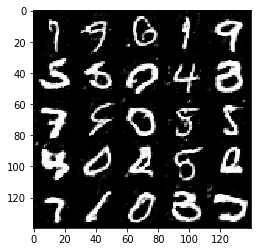

Epoch 2/2... Step 3710... Learning rate 0.0002010... Discriminator Loss: 0.4111... Generator Loss: 3.4224
Epoch 2/2... Step 3720... Learning rate 0.0002009... Discriminator Loss: 0.4970... Generator Loss: 2.5673
Epoch 2/2... Step 3730... Learning rate 0.0002009... Discriminator Loss: 0.5414... Generator Loss: 2.2527
Epoch 2/2... Step 3740... Learning rate 0.0002009... Discriminator Loss: 0.5339... Generator Loss: 1.7552
Epoch 2/2... Step 3750... Learning rate 0.0002009... Discriminator Loss: 0.4571... Generator Loss: 2.1913


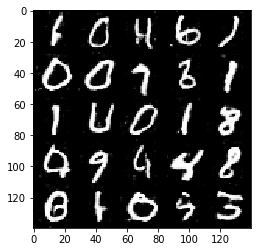

In [16]:
batch_size = 32
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Step 10... Learning rate 0.0004960... Discriminator Loss: 3.4437... Generator Loss: 0.1066
Epoch 1/1... Step 20... Learning rate 0.0004920... Discriminator Loss: 1.7653... Generator Loss: 0.5925
Epoch 1/1... Step 30... Learning rate 0.0004880... Discriminator Loss: 1.4871... Generator Loss: 0.9045
Epoch 1/1... Step 40... Learning rate 0.0004840... Discriminator Loss: 1.4895... Generator Loss: 0.8223
Epoch 1/1... Step 50... Learning rate 0.0004800... Discriminator Loss: 1.4028... Generator Loss: 0.8960
Epoch 1/1... Step 60... Learning rate 0.0004760... Discriminator Loss: 1.2389... Generator Loss: 1.2870
Epoch 1/1... Step 70... Learning rate 0.0004720... Discriminator Loss: 2.3179... Generator Loss: 0.3716
Epoch 1/1... Step 80... Learning rate 0.0004681... Discriminator Loss: 1.5119... Generator Loss: 0.7807
Epoch 1/1... Step 90... Learning rate 0.0004641... Discriminator Loss: 1.5756... Generator Loss: 0.5123
Epoch 1/1... Step 100... Learning rate 0.0004601... Discriminato

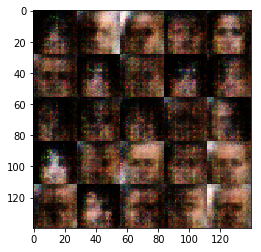

Epoch 1/1... Step 110... Learning rate 0.0004562... Discriminator Loss: 1.3840... Generator Loss: 0.9440
Epoch 1/1... Step 120... Learning rate 0.0004522... Discriminator Loss: 1.5287... Generator Loss: 0.5440
Epoch 1/1... Step 130... Learning rate 0.0004483... Discriminator Loss: 1.6738... Generator Loss: 0.4479
Epoch 1/1... Step 140... Learning rate 0.0004444... Discriminator Loss: 1.5042... Generator Loss: 0.7047
Epoch 1/1... Step 150... Learning rate 0.0004404... Discriminator Loss: 1.2555... Generator Loss: 1.0065
Epoch 1/1... Step 160... Learning rate 0.0004365... Discriminator Loss: 1.5025... Generator Loss: 0.7973
Epoch 1/1... Step 170... Learning rate 0.0004326... Discriminator Loss: 1.4912... Generator Loss: 0.9645
Epoch 1/1... Step 180... Learning rate 0.0004288... Discriminator Loss: 1.3623... Generator Loss: 1.1415
Epoch 1/1... Step 190... Learning rate 0.0004249... Discriminator Loss: 1.4933... Generator Loss: 0.7737
Epoch 1/1... Step 200... Learning rate 0.0004210... Dis

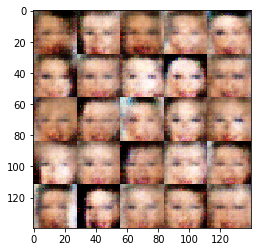

Epoch 1/1... Step 210... Learning rate 0.0004172... Discriminator Loss: 1.7888... Generator Loss: 0.4752
Epoch 1/1... Step 220... Learning rate 0.0004134... Discriminator Loss: 2.0861... Generator Loss: 0.2657
Epoch 1/1... Step 230... Learning rate 0.0004096... Discriminator Loss: 1.4759... Generator Loss: 0.7170
Epoch 1/1... Step 240... Learning rate 0.0004058... Discriminator Loss: 1.3005... Generator Loss: 0.9376
Epoch 1/1... Step 250... Learning rate 0.0004020... Discriminator Loss: 1.8778... Generator Loss: 0.3888
Epoch 1/1... Step 260... Learning rate 0.0003983... Discriminator Loss: 1.3546... Generator Loss: 0.8616
Epoch 1/1... Step 270... Learning rate 0.0003946... Discriminator Loss: 1.7374... Generator Loss: 0.6084
Epoch 1/1... Step 280... Learning rate 0.0003908... Discriminator Loss: 1.4624... Generator Loss: 0.8918
Epoch 1/1... Step 290... Learning rate 0.0003871... Discriminator Loss: 1.4936... Generator Loss: 0.7223
Epoch 1/1... Step 300... Learning rate 0.0003835... Dis

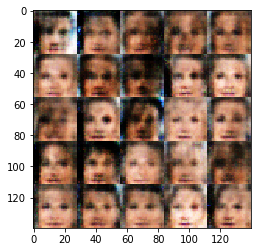

Epoch 1/1... Step 310... Learning rate 0.0003798... Discriminator Loss: 1.3751... Generator Loss: 0.6414
Epoch 1/1... Step 320... Learning rate 0.0003762... Discriminator Loss: 1.4299... Generator Loss: 0.9630
Epoch 1/1... Step 330... Learning rate 0.0003726... Discriminator Loss: 1.3115... Generator Loss: 1.0426
Epoch 1/1... Step 340... Learning rate 0.0003690... Discriminator Loss: 1.5701... Generator Loss: 0.6455
Epoch 1/1... Step 350... Learning rate 0.0003654... Discriminator Loss: 1.5715... Generator Loss: 0.7070
Epoch 1/1... Step 360... Learning rate 0.0003619... Discriminator Loss: 1.2934... Generator Loss: 0.7382
Epoch 1/1... Step 370... Learning rate 0.0003584... Discriminator Loss: 1.4266... Generator Loss: 0.8353
Epoch 1/1... Step 380... Learning rate 0.0003549... Discriminator Loss: 1.3420... Generator Loss: 1.0306
Epoch 1/1... Step 390... Learning rate 0.0003515... Discriminator Loss: 1.6617... Generator Loss: 0.9806
Epoch 1/1... Step 400... Learning rate 0.0003480... Dis

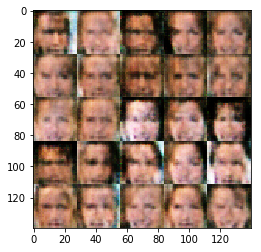

Epoch 1/1... Step 410... Learning rate 0.0003446... Discriminator Loss: 1.4614... Generator Loss: 0.7161
Epoch 1/1... Step 420... Learning rate 0.0003412... Discriminator Loss: 1.3960... Generator Loss: 0.9074
Epoch 1/1... Step 430... Learning rate 0.0003379... Discriminator Loss: 1.3621... Generator Loss: 0.7137
Epoch 1/1... Step 440... Learning rate 0.0003345... Discriminator Loss: 1.6253... Generator Loss: 0.8658
Epoch 1/1... Step 450... Learning rate 0.0003312... Discriminator Loss: 1.3600... Generator Loss: 0.8144
Epoch 1/1... Step 460... Learning rate 0.0003280... Discriminator Loss: 1.3810... Generator Loss: 0.9196
Epoch 1/1... Step 470... Learning rate 0.0003247... Discriminator Loss: 1.3176... Generator Loss: 0.7982
Epoch 1/1... Step 480... Learning rate 0.0003215... Discriminator Loss: 1.4986... Generator Loss: 0.6854
Epoch 1/1... Step 490... Learning rate 0.0003183... Discriminator Loss: 1.5693... Generator Loss: 0.8214
Epoch 1/1... Step 500... Learning rate 0.0003152... Dis

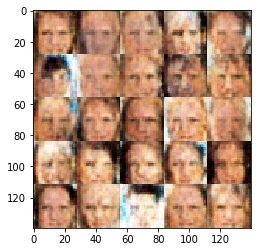

Epoch 1/1... Step 510... Learning rate 0.0003120... Discriminator Loss: 1.4028... Generator Loss: 0.8362
Epoch 1/1... Step 520... Learning rate 0.0003089... Discriminator Loss: 1.5560... Generator Loss: 0.7718
Epoch 1/1... Step 530... Learning rate 0.0003058... Discriminator Loss: 1.4205... Generator Loss: 0.7340
Epoch 1/1... Step 540... Learning rate 0.0003028... Discriminator Loss: 1.3997... Generator Loss: 0.8090
Epoch 1/1... Step 550... Learning rate 0.0002998... Discriminator Loss: 1.4609... Generator Loss: 0.8660
Epoch 1/1... Step 560... Learning rate 0.0002968... Discriminator Loss: 1.5039... Generator Loss: 1.0573
Epoch 1/1... Step 570... Learning rate 0.0002939... Discriminator Loss: 1.5173... Generator Loss: 0.6777
Epoch 1/1... Step 580... Learning rate 0.0002909... Discriminator Loss: 1.5395... Generator Loss: 0.5654
Epoch 1/1... Step 590... Learning rate 0.0002880... Discriminator Loss: 1.4749... Generator Loss: 0.7338
Epoch 1/1... Step 600... Learning rate 0.0002852... Dis

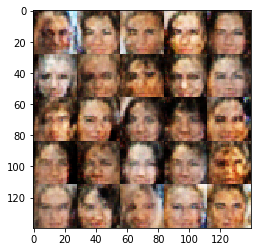

Epoch 1/1... Step 610... Learning rate 0.0002823... Discriminator Loss: 1.3740... Generator Loss: 0.8072
Epoch 1/1... Step 620... Learning rate 0.0002795... Discriminator Loss: 1.4771... Generator Loss: 0.7163
Epoch 1/1... Step 630... Learning rate 0.0002768... Discriminator Loss: 1.3986... Generator Loss: 0.9357
Epoch 1/1... Step 640... Learning rate 0.0002740... Discriminator Loss: 1.4914... Generator Loss: 0.6848
Epoch 1/1... Step 650... Learning rate 0.0002713... Discriminator Loss: 1.3965... Generator Loss: 0.8941
Epoch 1/1... Step 660... Learning rate 0.0002687... Discriminator Loss: 1.4500... Generator Loss: 0.6533
Epoch 1/1... Step 670... Learning rate 0.0002660... Discriminator Loss: 1.4741... Generator Loss: 0.6266
Epoch 1/1... Step 680... Learning rate 0.0002634... Discriminator Loss: 1.4586... Generator Loss: 0.6606
Epoch 1/1... Step 690... Learning rate 0.0002608... Discriminator Loss: 1.3857... Generator Loss: 0.7749
Epoch 1/1... Step 700... Learning rate 0.0002583... Dis

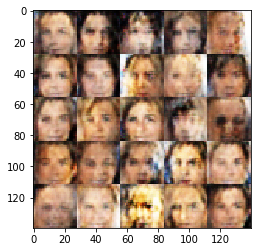

Epoch 1/1... Step 710... Learning rate 0.0002557... Discriminator Loss: 1.3635... Generator Loss: 0.6075
Epoch 1/1... Step 720... Learning rate 0.0002532... Discriminator Loss: 1.4143... Generator Loss: 0.8265
Epoch 1/1... Step 730... Learning rate 0.0002508... Discriminator Loss: 1.3636... Generator Loss: 0.9667
Epoch 1/1... Step 740... Learning rate 0.0002483... Discriminator Loss: 1.4215... Generator Loss: 0.6280
Epoch 1/1... Step 750... Learning rate 0.0002459... Discriminator Loss: 1.3309... Generator Loss: 0.7778
Epoch 1/1... Step 760... Learning rate 0.0002436... Discriminator Loss: 1.5521... Generator Loss: 0.5234
Epoch 1/1... Step 770... Learning rate 0.0002412... Discriminator Loss: 1.3957... Generator Loss: 0.6948
Epoch 1/1... Step 780... Learning rate 0.0002389... Discriminator Loss: 1.4980... Generator Loss: 0.5649
Epoch 1/1... Step 790... Learning rate 0.0002366... Discriminator Loss: 1.4518... Generator Loss: 0.7749
Epoch 1/1... Step 800... Learning rate 0.0002344... Dis

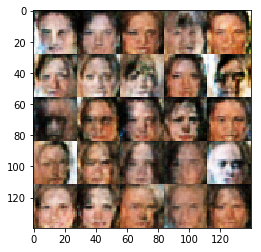

Epoch 1/1... Step 810... Learning rate 0.0002322... Discriminator Loss: 1.3271... Generator Loss: 0.8600
Epoch 1/1... Step 820... Learning rate 0.0002300... Discriminator Loss: 1.3739... Generator Loss: 0.7468
Epoch 1/1... Step 830... Learning rate 0.0002278... Discriminator Loss: 1.5771... Generator Loss: 0.7268
Epoch 1/1... Step 840... Learning rate 0.0002257... Discriminator Loss: 1.2767... Generator Loss: 0.8648
Epoch 1/1... Step 850... Learning rate 0.0002236... Discriminator Loss: 1.5031... Generator Loss: 0.7326
Epoch 1/1... Step 860... Learning rate 0.0002215... Discriminator Loss: 1.5192... Generator Loss: 0.6962
Epoch 1/1... Step 870... Learning rate 0.0002195... Discriminator Loss: 1.4108... Generator Loss: 0.7277
Epoch 1/1... Step 880... Learning rate 0.0002174... Discriminator Loss: 1.3264... Generator Loss: 0.8073
Epoch 1/1... Step 890... Learning rate 0.0002154... Discriminator Loss: 1.4107... Generator Loss: 0.6689
Epoch 1/1... Step 900... Learning rate 0.0002135... Dis

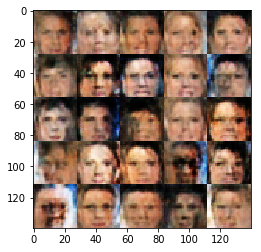

Epoch 1/1... Step 910... Learning rate 0.0002115... Discriminator Loss: 1.3304... Generator Loss: 0.7900
Epoch 1/1... Step 920... Learning rate 0.0002096... Discriminator Loss: 1.3988... Generator Loss: 0.7314
Epoch 1/1... Step 930... Learning rate 0.0002078... Discriminator Loss: 1.3513... Generator Loss: 0.8254
Epoch 1/1... Step 940... Learning rate 0.0002059... Discriminator Loss: 1.3803... Generator Loss: 0.8126
Epoch 1/1... Step 950... Learning rate 0.0002041... Discriminator Loss: 1.3334... Generator Loss: 0.6763
Epoch 1/1... Step 960... Learning rate 0.0002023... Discriminator Loss: 1.4633... Generator Loss: 0.8899
Epoch 1/1... Step 970... Learning rate 0.0002005... Discriminator Loss: 1.4024... Generator Loss: 0.6443
Epoch 1/1... Step 980... Learning rate 0.0001988... Discriminator Loss: 1.3444... Generator Loss: 0.8236
Epoch 1/1... Step 990... Learning rate 0.0001971... Discriminator Loss: 1.4256... Generator Loss: 0.6865
Epoch 1/1... Step 1000... Learning rate 0.0001954... Di

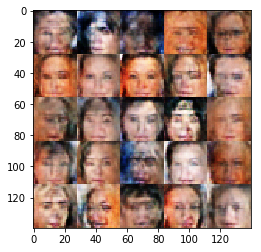

Epoch 1/1... Step 1010... Learning rate 0.0001937... Discriminator Loss: 1.3571... Generator Loss: 0.8741
Epoch 1/1... Step 1020... Learning rate 0.0001921... Discriminator Loss: 1.3330... Generator Loss: 0.8691
Epoch 1/1... Step 1030... Learning rate 0.0001904... Discriminator Loss: 1.3933... Generator Loss: 0.7952
Epoch 1/1... Step 1040... Learning rate 0.0001888... Discriminator Loss: 1.3507... Generator Loss: 0.6865
Epoch 1/1... Step 1050... Learning rate 0.0001873... Discriminator Loss: 1.4241... Generator Loss: 0.6444
Epoch 1/1... Step 1060... Learning rate 0.0001857... Discriminator Loss: 1.3894... Generator Loss: 1.0598
Epoch 1/1... Step 1070... Learning rate 0.0001842... Discriminator Loss: 1.3901... Generator Loss: 0.7604
Epoch 1/1... Step 1080... Learning rate 0.0001827... Discriminator Loss: 1.3584... Generator Loss: 0.7856
Epoch 1/1... Step 1090... Learning rate 0.0001812... Discriminator Loss: 1.4097... Generator Loss: 0.8601
Epoch 1/1... Step 1100... Learning rate 0.0001

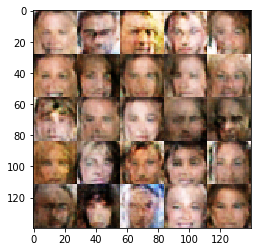

Epoch 1/1... Step 1110... Learning rate 0.0001784... Discriminator Loss: 1.3944... Generator Loss: 0.9072
Epoch 1/1... Step 1120... Learning rate 0.0001770... Discriminator Loss: 1.3661... Generator Loss: 0.8181
Epoch 1/1... Step 1130... Learning rate 0.0001756... Discriminator Loss: 1.4559... Generator Loss: 0.6798
Epoch 1/1... Step 1140... Learning rate 0.0001742... Discriminator Loss: 1.3976... Generator Loss: 0.8396
Epoch 1/1... Step 1150... Learning rate 0.0001729... Discriminator Loss: 1.3511... Generator Loss: 0.8297
Epoch 1/1... Step 1160... Learning rate 0.0001716... Discriminator Loss: 1.3332... Generator Loss: 0.7565
Epoch 1/1... Step 1170... Learning rate 0.0001703... Discriminator Loss: 1.3965... Generator Loss: 0.8988
Epoch 1/1... Step 1180... Learning rate 0.0001690... Discriminator Loss: 1.3592... Generator Loss: 0.6116
Epoch 1/1... Step 1190... Learning rate 0.0001678... Discriminator Loss: 1.4103... Generator Loss: 0.9163
Epoch 1/1... Step 1200... Learning rate 0.0001

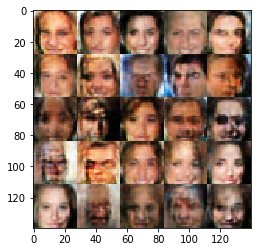

Epoch 1/1... Step 1210... Learning rate 0.0001653... Discriminator Loss: 1.4355... Generator Loss: 0.6584
Epoch 1/1... Step 1220... Learning rate 0.0001641... Discriminator Loss: 1.3901... Generator Loss: 0.7976
Epoch 1/1... Step 1230... Learning rate 0.0001630... Discriminator Loss: 1.3595... Generator Loss: 0.7574
Epoch 1/1... Step 1240... Learning rate 0.0001618... Discriminator Loss: 1.4218... Generator Loss: 0.7308
Epoch 1/1... Step 1250... Learning rate 0.0001607... Discriminator Loss: 1.3756... Generator Loss: 0.7421
Epoch 1/1... Step 1260... Learning rate 0.0001596... Discriminator Loss: 1.3661... Generator Loss: 0.7197
Epoch 1/1... Step 1270... Learning rate 0.0001585... Discriminator Loss: 1.3859... Generator Loss: 0.9419
Epoch 1/1... Step 1280... Learning rate 0.0001574... Discriminator Loss: 1.4038... Generator Loss: 0.8043
Epoch 1/1... Step 1290... Learning rate 0.0001563... Discriminator Loss: 1.4360... Generator Loss: 0.7316
Epoch 1/1... Step 1300... Learning rate 0.0001

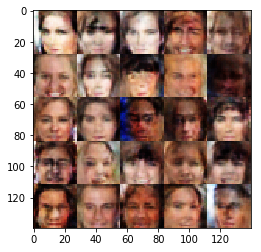

Epoch 1/1... Step 1310... Learning rate 0.0001543... Discriminator Loss: 1.4033... Generator Loss: 0.6936
Epoch 1/1... Step 1320... Learning rate 0.0001533... Discriminator Loss: 1.3671... Generator Loss: 0.7905
Epoch 1/1... Step 1330... Learning rate 0.0001523... Discriminator Loss: 1.4011... Generator Loss: 0.8694
Epoch 1/1... Step 1340... Learning rate 0.0001513... Discriminator Loss: 1.3754... Generator Loss: 0.8694
Epoch 1/1... Step 1350... Learning rate 0.0001504... Discriminator Loss: 1.3897... Generator Loss: 0.8336
Epoch 1/1... Step 1360... Learning rate 0.0001494... Discriminator Loss: 1.3914... Generator Loss: 0.7049
Epoch 1/1... Step 1370... Learning rate 0.0001485... Discriminator Loss: 1.3903... Generator Loss: 0.8138
Epoch 1/1... Step 1380... Learning rate 0.0001476... Discriminator Loss: 1.3812... Generator Loss: 0.7152
Epoch 1/1... Step 1390... Learning rate 0.0001467... Discriminator Loss: 1.3415... Generator Loss: 0.7404
Epoch 1/1... Step 1400... Learning rate 0.0001

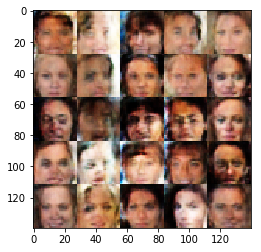

Epoch 1/1... Step 1410... Learning rate 0.0001450... Discriminator Loss: 1.3131... Generator Loss: 0.7545
Epoch 1/1... Step 1420... Learning rate 0.0001442... Discriminator Loss: 1.4038... Generator Loss: 0.7515
Epoch 1/1... Step 1430... Learning rate 0.0001433... Discriminator Loss: 1.3338... Generator Loss: 0.9799
Epoch 1/1... Step 1440... Learning rate 0.0001425... Discriminator Loss: 1.4017... Generator Loss: 0.9064
Epoch 1/1... Step 1450... Learning rate 0.0001417... Discriminator Loss: 1.3538... Generator Loss: 0.6960
Epoch 1/1... Step 1460... Learning rate 0.0001409... Discriminator Loss: 1.3852... Generator Loss: 0.8636
Epoch 1/1... Step 1470... Learning rate 0.0001402... Discriminator Loss: 1.3469... Generator Loss: 0.8258
Epoch 1/1... Step 1480... Learning rate 0.0001394... Discriminator Loss: 1.3808... Generator Loss: 0.6210
Epoch 1/1... Step 1490... Learning rate 0.0001387... Discriminator Loss: 1.4661... Generator Loss: 0.6430
Epoch 1/1... Step 1500... Learning rate 0.0001

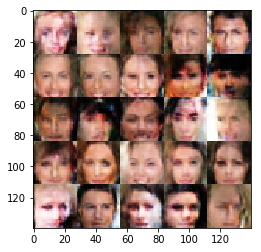

Epoch 1/1... Step 1510... Learning rate 0.0001372... Discriminator Loss: 1.4209... Generator Loss: 0.7616
Epoch 1/1... Step 1520... Learning rate 0.0001365... Discriminator Loss: 1.3807... Generator Loss: 0.8619
Epoch 1/1... Step 1530... Learning rate 0.0001358... Discriminator Loss: 1.3557... Generator Loss: 0.8555
Epoch 1/1... Step 1540... Learning rate 0.0001352... Discriminator Loss: 1.4283... Generator Loss: 0.7904
Epoch 1/1... Step 1550... Learning rate 0.0001345... Discriminator Loss: 1.2910... Generator Loss: 0.8727
Epoch 1/1... Step 1560... Learning rate 0.0001338... Discriminator Loss: 1.3816... Generator Loss: 0.7836
Epoch 1/1... Step 1570... Learning rate 0.0001332... Discriminator Loss: 1.3667... Generator Loss: 0.8474
Epoch 1/1... Step 1580... Learning rate 0.0001326... Discriminator Loss: 1.3706... Generator Loss: 0.6773


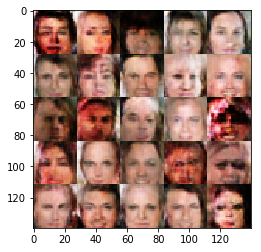

In [17]:
batch_size = 128
z_dim = 256
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.